In [ ]:
# path, venv, git bash terminal useful commands:
# cd C:/Users/marti/Desktop/AdventureWorks-msSQL-Python
# source .venv/Scripts/activate

# 1. Drivrutiner för Python och SQL connection.

In [1]:
import pyodbc
pyodbc.drivers()

['SQL Server',
 'ODBC Driver 18 for SQL Server',
 'Microsoft Access Driver (*.mdb, *.accdb)',
 'Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)',
 'Microsoft Access Text Driver (*.txt, *.csv)',
 'Microsoft Access dBASE Driver (*.dbf, *.ndx, *.mdx)']

# 2. Definierad Python och SQL connection samt funktion.

In [2]:
import pandas as pd
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

# quote_plus motverkar UTF-8 issues i connection.

user = "SA"
password = quote_plus(input(""))
server = "localhost:1433"
database = "AdventureWorks2025"
driver = quote_plus("ODBC Driver 18 for SQL Server")

connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)

In [3]:
def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)

In [4]:
query_test = """
SELECT TOP 5 *
FROM Person.person
"""

query_test_df = query_df(query_test)
query_test_df.head()

C:\Users\marti\AppData\Local\Temp\ipykernel_25156\4012941776.py:2: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect() as conn:


,BusinessEntityID,PersonType,NameStyle,Title,FirstName,MiddleName,LastName,Suffix,EmailPromotion,AdditionalContactInfo,Demographics,rowguid,ModifiedDate
0,1,EM,False,None,Ken,J,Sánchez,None,0,None,"<IndividualSurvey xmlns=""http://schemas.micros...",92C4279F-1207-48A3-8448-4636514EB7E2,2020-01-07
1,2,EM,False,None,Terri,Lee,Duffy,None,1,None,"<IndividualSurvey xmlns=""http://schemas.micros...",D8763459-8AA8-47CC-AFF7-C9079AF79033,2019-01-23
2,3,EM,False,None,Roberto,None,Tamburello,None,0,None,"<IndividualSurvey xmlns=""http://schemas.micros...",E1A2555E-0828-434B-A33B-6F38136A37DE,2018-11-03
3,4,EM,False,None,Rob,None,Walters,None,0,None,"<IndividualSurvey xmlns=""http://schemas.micros...",F2D7CE06-38B3-4357-805B-F4B6B71C01FF,2018-11-27
4,5,EM,False,Ms.,Gail,A,Erickson,None,0,None,"<IndividualSurvey xmlns=""http://schemas.micros...",F3A3F6B4-AE3B-430C-A754-9F2231BA6FEF,2018-12-29


# 3. Genomgång av Uppgifter för AdventureWorks2025 db.

## 3.1 - Uppgift 1:

Antal produkter per kategori.

In [5]:
query_1 = """
SELECT ISNULL(ppc.Name, 'Okategoriserad') AS Kategori, 
        COUNT(pp.ProductID) AS AntalProdukter
FROM Production.Product AS pp
LEFT JOIN Production.ProductSubcategory AS pps
  ON pp.ProductSubcategoryID = pps.ProductSubcategoryID
LEFT JOIN Production.ProductCategory AS ppc
  ON pps.ProductCategoryID = ppc.ProductCategoryID
GROUP BY ppc.Name
ORDER BY AntalProdukter DESC;
"""

query_1_df = query_df(query_1)
query_1_df

,Kategori,AntalProdukter
0,Okategoriserad,209
1,Components,134
2,Bikes,97
3,Clothing,35
4,Accessories,29


Eftersom Person.Person.ProductID är en primär nyckel med inkrement, behövs inte DISTINCT inom COUNT(pp.ProductID).

Tack vare LEFT JOIN, med Production.Product tabellen på vänster sida, räknar `query 1` rader (produkter) som saknar ProductSubcategoryID såväl som produkter som *är* kategoriserade. En INNER JOIN skulle missat okategoriserade rader.

Visualisering:

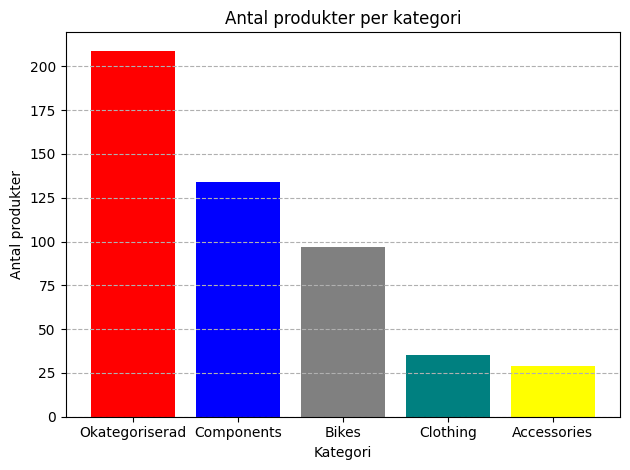


Kategori med flest produkter:
Kategori          Components
AntalProdukter           134
dtype: object

Kategori med minst produkter:
Kategori          Accessories
AntalProdukter             29
dtype: object


In [6]:
import matplotlib.pyplot as plt

colors = ['red', 'blue', 'grey', 'teal', 'yellow']
plt.bar(query_1_df.Kategori, query_1_df['AntalProdukter'], color=colors)
plt.title("Antal produkter per kategori")
plt.xlabel("Kategori")
plt.ylabel("Antal produkter")
plt.grid(True, axis='y', linestyle="--")
plt.tight_layout()
plt.show()

# Printa flest & minst produkter
# Sortera ut Okategoriserade produkter
query_1_df_mod = query_1_df.iloc[1:,:]
print("\nKategori med flest produkter:")
print(query_1_df_mod.max())
print("\nKategori med minst produkter:")
print(query_1_df_mod.min())

Med kategorinamn och gruppering efter kategorinamn, räknar count utav produkt-id ut hur många produkter som finns per kategori. 

Vid önskan om att inspektera okategoriserade produkter, körs en LEFT JOIN & WHERE IS NULL query:

In [7]:
query_1_bonus = """
SELECT 
    pp.ProductID AS ProduktID,
    pp.Name AS ProduktNamn,
    pp.ProductSubcategoryID AS SubkategoriID,
    pps.Name AS SubkategoriNamn,
    ppc.Name AS KategoriNamn
FROM Production.Product AS pp
LEFT JOIN Production.ProductSubcategory AS pps
    ON pp.ProductSubcategoryID = pps.ProductSubcategoryID
LEFT JOIN Production.ProductCategory AS ppc
    ON pps.ProductCategoryID = ppc.ProductCategoryID
WHERE pp.ProductSubcategoryID IS NULL
ORDER BY pp.ProductID;
"""

query_1_bonus_df = query_df(query_1_bonus)
query_1_bonus_df.tail(3)

,ProduktID,ProduktNamn,SubkategoriID,SubkategoriNamn,KategoriNamn
206,534,Top Tube,None,None,None
207,535,Tension Pulley,None,None,None
208,679,Rear Derailleur Cage,None,None,None


Längden på resulterande tabell verkar stämma mot grafens stapel *Okategoriserad*.

Vidare granskning berör frekvens av kategorier med aktiva produkter.

In [8]:
query_1_active = """
SELECT ISNULL(ppc.Name, 'Okategoriserad') AS Kategori, 
        COUNT(pp.ProductID) AS AntalProdukter
FROM Production.Product AS pp
LEFT JOIN Production.ProductSubcategory AS pps
  ON pp.ProductSubcategoryID = pps.ProductSubcategoryID
LEFT JOIN Production.ProductCategory AS ppc
  ON pps.ProductCategoryID = ppc.ProductCategoryID
WHERE pp.SellEndDate IS NULL
GROUP BY ppc.Name
ORDER BY AntalProdukter DESC;
"""

query_1_active_df = query_df(query_1_active)
diff = query_1_df.AntalProdukter - query_1_active_df.AntalProdukter
query_1_active_copy = query_1_active_df.copy()
query_1_active_copy['Differens'] = diff
query_1_active_copy['AntalProdukterUtanAktivaFilter'] = query_1_df.AntalProdukter
query_1_active_copy

,Kategori,AntalProdukter,Differens,AntalProdukterUtanAktivaFilter
0,Okategoriserad,209,0,209
1,Components,95,39,134
2,Bikes,60,37,97
3,Accessories,22,13,35
4,Clothing,20,9,29


I resulterande tabell med tillagd kolumn Differens via python-kod (visar antalet inaktiva produkter), som givetvis skulle gå att ta fram via SQL query också, ser vi att inaktiva produkter inom Components är 39st, och så vidare. Alltså är potentiellt `WHERE pp.SellEndDate IS NULL` ett välbehövligt filter för `query 1` ifall inaktiva produkter ska borträknas i kategoriuppdelningen.

## 3.2 Uppgift 2:

Vilka produktkategorier genererar mest intäkter?